In [1]:
import os
import numpy as np
import h5py
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json
import csv
import pandas as pd
import random

from datetime import datetime
from tqdm import tqdm
from PIL import Image


# Scikit-learn imports
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, top_k_accuracy_score, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from torchvision import models
import torch.nn.functional as F
from torchcam.methods import GradCAM
from torchvision import transforms
from torchcam.utils import overlay_mask

First, the list of chosen bird species is defined:

In [2]:
species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

And some settings are defined for pre-processing the images.

In [3]:
MODEL_SAVE_DIR = 'saved_models/full_image_model'
RESULT_DIR = 'images'  
DATA_DIR = "full_image_dataset"
AUGMENTED_DATA_DIR = "augmented_dataset"
DATASET = 'dataset_20250519.h5'
BATCH_SIZE = [16]
N_SPLITS = 5                            
NUM_EPOCHS = 25
NUM_CLASSES = len(species)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Experiment B parameters
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0
USE_MIXUP = True
USE_CUTMIX = True

# Experiment E parameters
UNCERTAINTY_THRESHOLD = 0.6

#GRADCAM
ACTIVATION = None
GRADIENT = None

In [4]:
def openH5File(filepath, fold_idx=None):
    file = h5py.File(filepath, 'r')
    datasets = {}

    if fold_idx is not None:
        try:
            fold_group = file[f'cross_validation/fold_{fold_idx}']
            datasets['X_train'] = fold_group['X_train']
            datasets['y_train'] = fold_group['y_train']
            datasets['X_val'] = fold_group['X_val']
            datasets['y_val'] = fold_group['y_val']
        except KeyError:
            raise ValueError(f"Fold {fold_idx} not found in file. Available groups: {list(file['cross_validation'].keys())}")
    
    datasets['X_test'] = file['test']['X_test']
    datasets['y_test'] = file['test']['y_test']
    return datasets

def createDataloaders(X_h5, y_h5, batch_size=BATCH_SIZE, shuffle=False):
    X_np = X_h5[:]  # (N, H, W, C)
    if X_np.ndim == 4:
        X_np = np.transpose(X_np, (0, 3, 1, 2))  # to (N, C, H, W)

    X_tensor = torch.from_numpy(X_np).float()
    y_tensor = torch.from_numpy(y_h5[:]).long()
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size, shuffle, num_workers=4, pin_memory=True)
    return dataloader

def getDataloaders(filepath, fold_idx, batch_size):
    dataset = openH5File(f"{filepath}", fold_idx)
    test_loader = createDataloaders(dataset['X_test'], dataset['y_test'], batch_size)
    if fold_idx is not None:
        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size, shuffle=True)
        val_loader = createDataloaders(dataset['X_val'], dataset['y_val'], batch_size)

    return train_loader, val_loader, test_loader

In [10]:
def getModel(name, nClasses, dropout_rate=0):
    if name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
    elif name == 'efficientnet_V2':
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
    
    return model.to(DEVICE)

def getOptimizer(model, params):
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    return optimizer


def apply_mixup_cutmix(inputs, labels, params):
    """Applies MixUp or CutMix augmentation to a batch"""
    if not (USE_MIXUP or USE_CUTMIX):
        return inputs, (labels, labels, 1.0)
    
    use_mixup = params.get('use_mixup', False)
    use_cutmix = params.get('use_cutmix', False)
    
    if use_cutmix:
        lam = np.random.beta(CUTMIX_ALPHA, CUTMIX_ALPHA)
        b, _, h, w = inputs.size()
        
        # Generate random bounding box
        rx = random.randint(0, w)
        ry = random.randint(0, h)
        rw = int(w * np.sqrt(1 - lam))
        rh = int(h * np.sqrt(1 - lam))
        x1 = max(0, rx - rw // 2)
        y1 = max(0, ry - rh // 2)
        x2 = min(w, x1 + rw)
        y2 = min(h, y1 + rh)
        
        # Apply CutMix
        inputs[:, :, y1:y2, x1:x2] = inputs.flip(0)[:, :, y1:y2, x1:x2]
        lam = 1 - (x2 - x1) * (y2 - y1) / (w * h)
    else:
        # Apply MixUp
        lam = np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA)
        inputs = lam * inputs + (1 - lam) * inputs.flip(0)
    
    # Return mixed labels and lambda
    return inputs, (labels, labels.flip(0), lam)

In [11]:
def trainModel(model, train_loader, val_loader, params):
    criterion = nn.CrossEntropyLoss()
    optimizer = getOptimizer(model, params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) if params['scheduler'] else None
    
    best_f1 = 0
    THRESHOLD = 5
    improvementCounter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            # Apply MixUp/CutMix only during training
            if USE_MIXUP or USE_CUTMIX:
                inputs, (labels1, labels2, lam) = apply_mixup_cutmix(inputs, labels, params)

            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if USE_MIXUP or USE_CUTMIX:
                loss = lam * criterion(outputs, labels1) + (1 - lam) * criterion(outputs, labels2)
            else:
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if scheduler:
            scheduler.step(val_loss)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            improvementCounter = 0
        else:
            improvementCounter += 1
            if improvementCounter >= THRESHOLD:
                break

    return history, best_f1

In [ ]:
def generate_class_gradcams(model, test_loader, species_list):
    """Generate one Grad-CAM visualization per class"""
    original_training = model.training
    model.eval()
    
    target_layer = get_last_conv_layer(model)
    cam_extractor = GradCAM(model, target_layer=target_layer)
    class_samples = {i: None for i in range(len(species_list))}
    
    # First pass: find one correct prediction per class
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
            
        for i in range(inputs.size(0)):
            label = labels[i].item()
            if class_samples[label] is None and preds[i] == label:
                class_samples[label] = inputs[i].unsqueeze(0)
        if all(v is not None for v in class_samples.values()):
            break
    
    # Second pass: generate Grad-CAM
    cam_results = []
    for class_idx, img_tensor in class_samples.items():
        if img_tensor is None:
            continue
        
        img = img_tensor.clone().detach().requires_grad_(True)
        with torch.set_grad_enabled(True):
            out = model(img)
            activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

            if activation_map is not None:
                img_vis = img_tensor.squeeze().cpu()
                result = overlay_mask(
                    to_pil_image(img_vis),
                    to_pil_image(activation_map[0].squeeze(0)), 
                    alpha=0.5
                )
                cam_results.append({
                    'class_name': species_list[class_idx],
                    'image': np.array(result),
                    'true_label': species_list[class_idx],
                    'pred_label': species_list[class_idx]
                })
    
    cam_extractor.remove_hooks()
    model.train(original_training)
    
    return cam_results


def get_last_conv_layer(model):
    """Dynamically find the last Conv2d layer in EfficientNet."""
    conv_layers = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append(module)

    if not conv_layers:
        raise ValueError("No Conv2d layers found in model.")

    return conv_layers[-1]


def save_class_gradcams(gradcam_results, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for result in gradcam_results:
        filename = f"gradcam_{result['class_name']}.png"
        image = result['image']
        if isinstance(image, np.ndarray):
            image = Image.fromarray((image * 255).astype(np.uint8)) if image.max() <= 1.0 else Image.fromarray(image)
        image.save(os.path.join(save_dir, filename))
        
def plot_class_gradcams(gradcam_results):
    """Plot Grad-CAM visualizations in a grid"""
    n_classes = len(gradcam_results)
    cols = 3
    rows = (n_classes + cols - 1) // cols
    
    plt.figure(figsize=(15, 5*rows))
    for i, result in enumerate(gradcam_results):
        plt.subplot(rows, cols, i+1)
        plt.imshow(result['image'], cmap='hot')
        plt.title(result['class_name'])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



def plotting(history, cm, metrics_dict, species, cam_images=None):
    plt.figure(figsize=(24, 12))

    # Plot training history
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=species, yticklabels=species)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot precision-recall curve
    plt.subplot(2, 3, 3)
    plt.plot(metrics_dict['recall'],
            metrics_dict['precision'], lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AUPRC: {metrics_dict["macro_auprc"]:.4f})')

    # Plot Grad-CAM visualizations
    if cam_images:
        for i, result in enumerate(cam_images[:6]):  # Show max 6
            plt.subplot(2, 3, i + 1) 
            plt.imshow(result['image'], cmap='hot')
            plt.title(result['class_name'])
            plt.axis('off') 


    plt.tight_layout()
    plot_path = os.path.join(MODEL_SAVE_DIR, RESULT_DIR, f"training_results_{datetime.now().strftime("%Y%m%d")}.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()

    # Save individual Grad-CAM images
    if cam_images:
        for i, cam_entry in enumerate(cam_images[:3]):
            img_path = os.path.join(MODEL_SAVE_DIR, RESULT_DIR, f"gradcam_{i}_{datetime.now().strftime('%Y%m%d')}.png")
            Image.fromarray(cam_entry['image']).save(img_path)


In [13]:
def gridSearch(filepath, n_splits, hyperparams):
    results_log = {
        "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S"),
        "total_combinations": len(list(itertools.product(*hyperparams.values()))),
        "best_f1": 0,
        "best_params": None,
        "all_results": []
    }

    # Generate all possible hyperparameter combinations
    keys, values = zip(*hyperparams.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    print(f"\nBeginning GridSearch with {len(param_combinations)} combinations...")
    
    for params in tqdm(param_combinations):
        torch.cuda.reset_peak_memory_stats()
        print("\n" + "="*50)
        print(f"Testing combination: {params}")
        fold_f1_scores = []
        fold_acc_scores = []
        start_time = time.time()
        
        # Cross-validation loop
        for fold_idx in range(1, n_splits+1):
            train_loader, val_loader, _ = getDataloaders(filepath, fold_idx, params['batch_size'])
            model = getModel(params['model_name'], NUM_CLASSES, params.get('dropout_rate', 0))
            model.to(DEVICE)
            history, fold_f1 = trainModel(model, train_loader, val_loader, params)
            print(f"Fold {fold_idx} Best F1 Score: {fold_f1:.4f}")
            fold_f1_scores.append(fold_f1)
            fold_acc_scores.append(history['val_acc'][-1].item())

            # Clear memory
            del model
            gc.collect()
            torch.cuda.empty_cache()
        
        # Calculate average F1 across folds
        avg_f1 = np.mean(fold_f1_scores)
        std_f1 = np.std(fold_f1_scores)
        avg_acc = np.mean(fold_acc_scores)
        std_acc = np.std(fold_acc_scores)
        time_taken = time.time() - start_time

        # Record this combination's results
        result_entry = {
            "params": params,
            "avg_f1": avg_f1,
            "std_f1": std_f1,
            "mean_acc": avg_acc,
            "std_acc": std_acc,
            "f1_scores": fold_f1_scores,
            "acc_scores": fold_acc_scores,
            "memory_used_GB": torch.cuda.max_memory_allocated()/1e9,
            "time_taken": time_taken
        }
        results_log["all_results"].append(result_entry)
        
        # Update best parameters if improved
        if avg_f1 > results_log["best_f1"]:
            results_log["best_f1"] = avg_f1
            results_log["best_params"] = params
            print(f"New best parameters found with F1: {avg_f1:.4f}")

    # Finalize results        
    print("\nGridSearch completed!")
    torch.save(results_log["best_params"], os.path.join(MODEL_SAVE_DIR, f'gridsearch_setup1_{datetime.now().strftime("%Y%m%d")}.pth'))

    # Save JSON log
    json_path = os.path.join(MODEL_SAVE_DIR, f"gridsearch_results_{datetime.now().strftime("%Y%m%d")}.json")
    with open(json_path, 'w') as f:
        json.dump(results_log, f, indent=4)

    # Save CSV results
    csv_path = os.path.join(MODEL_SAVE_DIR, f"gridsearch_results_{datetime.now().strftime("%Y%m%d")}.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        header = ["params", "avg_f1", "std_f1", "mean_acc", "std_acc", "f1_scores", "acc_scores", "memory_used_GB", "time_taken"]
        writer.writerow(header)
        for res in results_log["all_results"]:
            writer.writerow([
                str(res["params"]), res["avg_f1"], res["std_f1"],
                res["mean_acc"], res["std_acc"],
                res["f1_scores"], res["acc_scores"],
                res["memory_used_GB"], res["time_taken"]
            ])

def bestTrainModel(filepath, best_params):
    model = getModel(best_params['model_name'], nClasses=NUM_CLASSES, dropout_rate=best_params['dropout_rate'])
    train_loader, val_loader, test_loader = getDataloaders(filepath, fold_idx=1, batch_size=BATCH_SIZE[0])

    history, _ = trainModel(model, train_loader, val_loader, best_params)

    # Evaluate on test set
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    total_samples = 0

    cam_images = generate_class_gradcams(model, test_loader, species)
    # Save and plot
    save_class_gradcams(cam_images, os.path.join(MODEL_SAVE_DIR, RESULT_DIR))
    plot_class_gradcams(cam_images)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            
            # Apply uncertainty threshold (Experiment E)
            uncertain_mask = max_probs < UNCERTAINTY_THRESHOLD
            preds[uncertain_mask] = -1  # Mark as uncertain
            
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Filter out uncertain predictions for metrics calculation
    certain_mask = np.array(all_preds) != -1
    certain_preds = np.array(all_preds)[certain_mask]
    certain_labels = np.array(all_labels)[certain_mask]
    certain_probs = np.array(all_probs)[certain_mask]

    cm = confusion_matrix(certain_labels, certain_preds)
    f1 = f1_score(certain_labels, certain_preds, average='weighted')
    top1_acc = accuracy_score(certain_labels, certain_preds)
    test_loss /= total_samples

    labels_range = list(range(NUM_CLASSES))
    try:
        top3_acc = top_k_accuracy_score(certain_labels, certain_probs, k=3, labels=labels_range)
    except ValueError:
        top3_acc = 0.0

    try:
        binarized_labels = label_binarize(certain_labels, classes=labels_range)
        auprc_macro = roc_auc_score(binarized_labels, certain_probs, average='macro', multi_class='ovr')
    except Exception:
        auprc_macro = 0.0

    # Compute PR curve for the first class (just for plotting)
    precision, recall, _ = precision_recall_curve(binarized_labels[:, 0], certain_probs[:, 0])

    metrics = {
        'test_loss': test_loss,
        'top1_accuracy': top1_acc,
        'top3_accuracy': top3_acc,
        'f1_score': f1,
        'confusion_matrix': cm,
        'macro_auprc': auprc_macro,
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'uncertainty_rate': 1 - (certain_mask.sum() / len(all_preds)),
        'threshold': UNCERTAINTY_THRESHOLD
    }

    return model, history, metrics, cam_images

d:\Github\Bird-Recognition\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Github\Bird-Recognition\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Github\Bird-Recognition\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Github\Bird-Recognition\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Github\Bird-Recognition\.venv\Lib\site-packages\torch\utils\data\

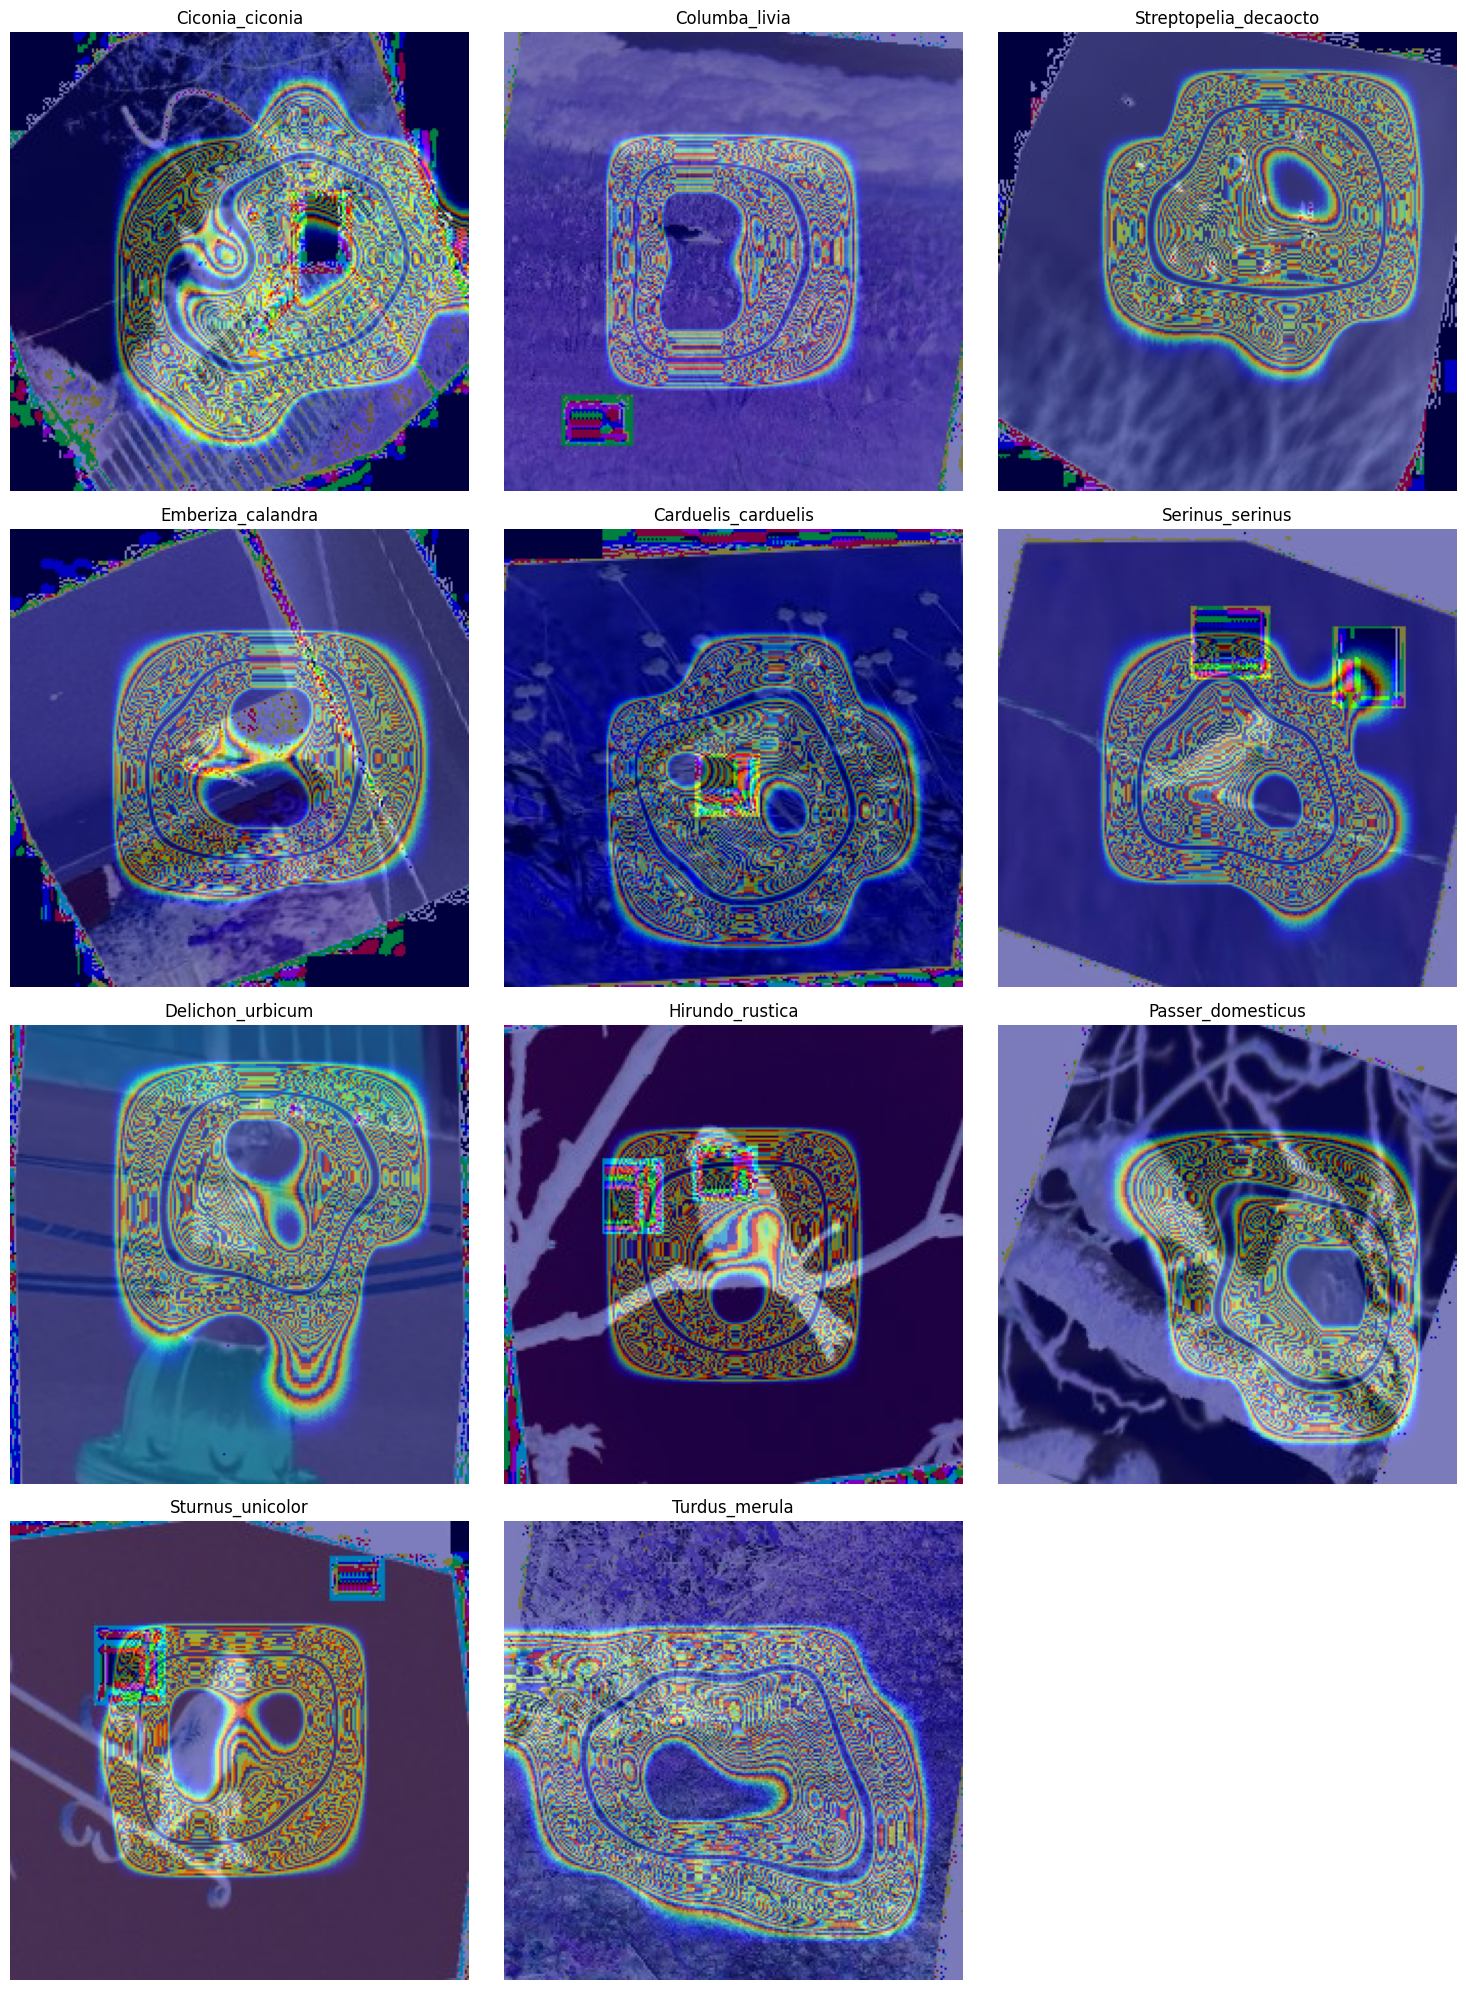

In [14]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(MODEL_SAVE_DIR, RESULT_DIR), exist_ok=True)
BEST_PARAMS = 'gridsearch_setup1_20250506.pth'
best_params = torch.load(os.path.join(MODEL_SAVE_DIR, BEST_PARAMS))
best_model, best_history, best_metrics, best_camImages = bestTrainModel(f"{DATA_DIR}/{DATASET}", best_params)
speciesModel = best_model.species if hasattr(best_model, 'species') else species

#Generate confusion matrix
cm = best_metrics['confusion_matrix']
        
#Plot results
plotting(
    history=best_history,
    cm=cm,
    metrics_dict=best_metrics,
    species=speciesModel,
    cam_images=best_camImages
)
        
# Save final model and metrics
final_model_path = os.path.join(MODEL_SAVE_DIR, f'final_model_{datetime.now().strftime("%Y%m%d")}.pth')
torch.save({
    'model_state_dict': best_model.state_dict(),
    'best_params': best_params,
    'metrics': best_metrics,
    'class_names': speciesModel,
    'training_history': best_history
}, final_model_path)

# Save metrics separately
with open(os.path.join(MODEL_SAVE_DIR, f"final_metrics_{datetime.now().strftime("%Y%m%d")}.json"), 'w') as f:
    json.dump({
        'test_loss': best_metrics['test_loss'],
        'top1_accuracy': best_metrics['top1_accuracy'],
        'top3_accuracy': best_metrics['top3_accuracy'],
        'f1_score': best_metrics['f1_score'],
        'macro_auprc': best_metrics['macro_auprc'],
        'precision_recall_curve': {
            'precision': best_metrics['precision'],
            'recall': best_metrics['recall']
        },
        'uncertainty_rate': best_metrics['uncertainty_rate'],
        'threshold': best_metrics['threshold']
    }, f, indent=2)

# Save confusion matrix
np.save(os.path.join(MODEL_SAVE_DIR, f"confusion_matrix_{datetime.now().strftime("%Y%m%d")}.npy"), cm)